# Integrantes
- Ambroa, Nicolás - 229/13 - ambroanicolas@hotmail.com
- Gaustein, Diego - 586/09 - diego@gaustein.com.ar

In [2]:
import scipy.io as sio
from scipy.signal import welch
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
import pylab
from glob import glob
from functools import partial
from math import ceil
from os.path import split, splitext
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations, product
import random
from sklearn.metrics import mutual_info_score

random.seed(42)
%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

### Generamos constantes a utilizar a lo largo del TP, ademas de funciones que ayudan con la carga de datos. Redefinimos welch para mantenerla siempre con la misma frecuencia y nfft.

In [3]:
def loadSubject(filename):
    return sio.loadmat(filename)['data']

def allSubjects():
    return sorted(glob('dataset/*'))

sujetoP01 = loadSubject('dataset/P01.mat')
cant_muestras = len(sujetoP01[0, 0])
cant_electrodos = len(sujetoP01[0])
long_epoch = 0.8  # segundos
nfft = 2047
longitud_de_poderes = ceil(nfft / 2)
bandas = [0, 4, 8, 13, 30, 45] 
nombre_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Redefino welch para que siempre tenga el mismo fs y nfft
welch_eeg = partial(welch, fs=90, nfft=nfft, nperseg=cant_muestras)

In [5]:
electrodos = [8, 44, 80, 131, 185] 

frecuencias, _ = welch_eeg(sujetoP01[0, 0], fs=90)

def heatmap(desde=0, hasta=cant_muestras):
    epochs = []
    for epoch in range(len(sujetoP01)):
        poderes_espectrales = []
        for electrodo in electrodos:
            frecuencias, poder_espectral = welch_eeg(sujetoP01[epoch, electrodo][desde:hasta])
            poderes_espectrales.append(np.array(poder_espectral))

        matriz = np.stack(poderes_espectrales)
        medias_de_poderes_espectrales = np.mean(matriz, axis=0)
        epochs.append(np.log(medias_de_poderes_espectrales))

    sns.heatmap(np.array(epochs).transpose())

## a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color como en el ejemplo

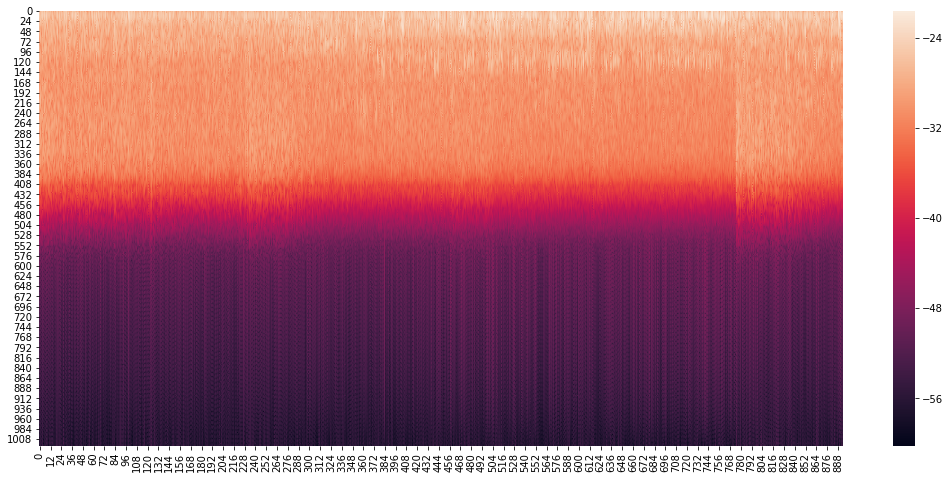

In [4]:
heatmap()

## a.2) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal, como en el ejemplo:

(0, 12)

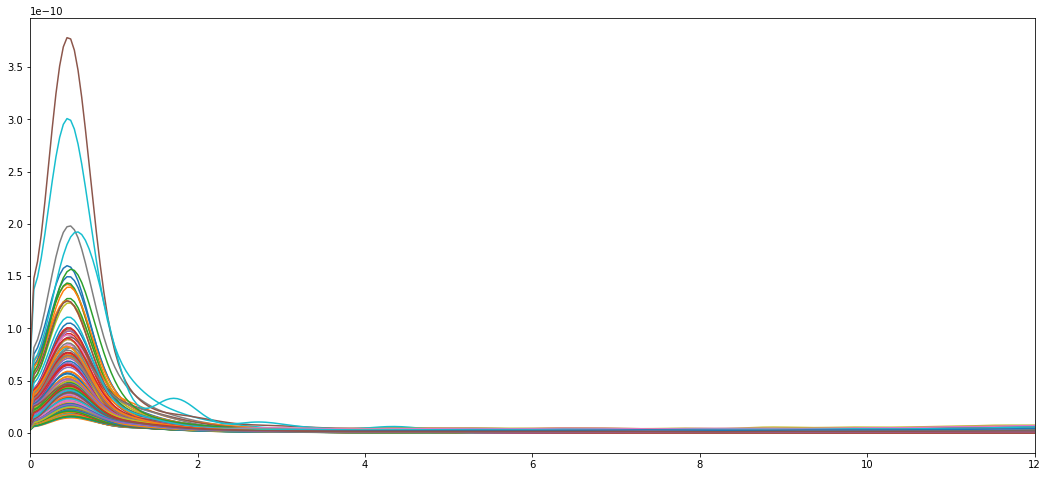

In [5]:
def potencia_media_por_frecuencia(electrodo=0):
    epochs = []
    for epoch in range(len(sujetoP01)):
        frecuencias, poder_espectral = welch_eeg(sujetoP01[epoch, electrodo])
        epochs.append(poder_espectral)
    
    # matriz donde las filas son epochs, las columnas frecuencias y los valores poderes espectrales
    matriz = np.stack(epochs)
    medias_de_poderes_espectrales = np.mean(matriz, axis=0)
    plt.plot(frecuencias, medias_de_poderes_espectrales)

for electrodo in range(cant_electrodos):
    potencia_media_por_frecuencia(electrodo)
    
plt.xlim(0, 12)

Generamos una función auxiliar para binnear las frecuencias y la testeamos

In [6]:
def getBanda(frecuencia):
    """ [0, 4, 8, 13, 30, 45]  # Delta, Theta, Alpha, Beta, Gamma """
    res = 0
    for indice, lim_izq in enumerate(bandas):
        if frecuencia >= lim_izq:
            res = indice
        else:
            break
    return res

assert getBanda(1) == 0
assert getBanda(6) == 1
assert getBanda(10) == 2
assert getBanda(15) == 3
assert getBanda(33) == 4
assert getBanda(50) == 5

## b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

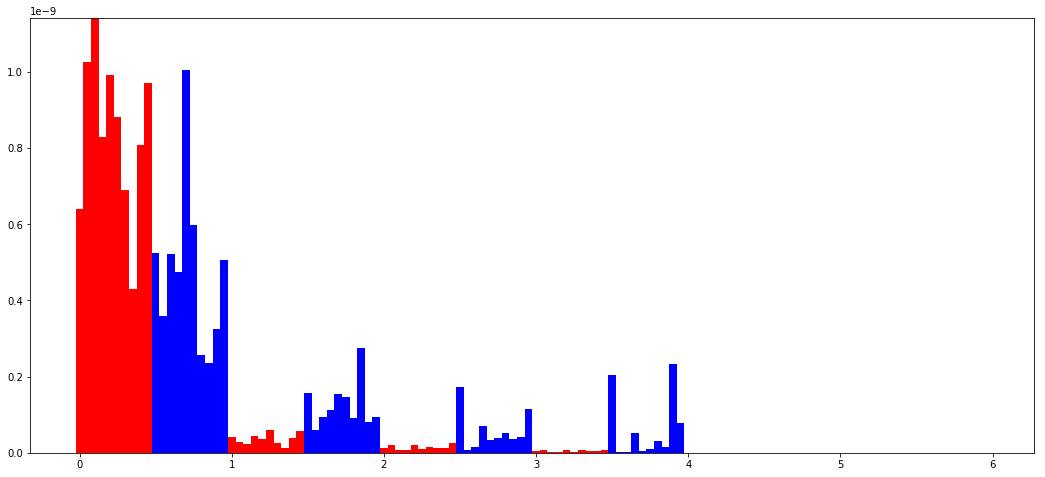

In [7]:
barwidth = 1 / len(allSubjects())

# Calculamos el promedio de los poderes espectrales para un sujeto dado, todos los epochs y los
# electrodos indicados.
welch
bins_por_sujeto = {}
for index, filename in enumerate(allSubjects()):
    poderes_por_sujeto = np.zeros(longitud_de_poderes)
    bins = np.zeros(len(bandas))
    cantIteraciones = 0
    subject_data = loadSubject(filename)  # epoch, electrodo, muestra
    
    for epoch in subject_data:
        for num_electrodo in electrodos:
            electrodo = epoch[num_electrodo]
            frecuencias, poder_espectral = welch_eeg(electrodo)
            poderes_por_sujeto += poder_espectral
            cantIteraciones += 1

    poderes_por_sujeto /= cantIteraciones
    
    for frecuencia, poder in zip(frecuencias, poderes_por_sujeto):
        bins[getBanda(frecuencia)] += poder
        
    bins_por_sujeto[filename] = bins
    
    # Generamos un grafico de barras, separando por bandas y sujeto.
    # Los datos rojos corresponden a los sujetos P, mientras que los azules corresponden a los sujetos S.
    # El eje X contiene la separacion por bandas en orden Delta-Theta-Alfa-Beta-Gamma
    plt.bar(np.arange(len(bandas)) + index * barwidth, bins, width=barwidth,
           color='red' if 'P' in filename else 'blue', label='bandas')

## c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.

In [8]:
# Separamos en P y S
def get_letter(filename):
    return splitext(split(filename)[1])[0][0]

filenames = [get_letter(fn) for fn in bins_por_sujeto.keys()]
bandas_alpha = [bin[2] for bin in bins_por_sujeto.values()]
bandas_alpha_log = np.log(bandas_alpha)

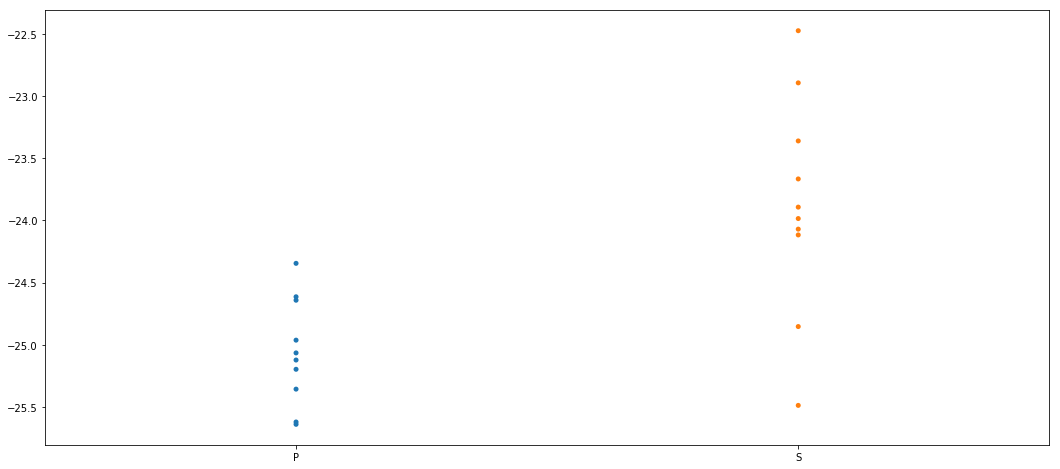

In [9]:
sns.stripplot(x=filenames, y=bandas_alpha_log)

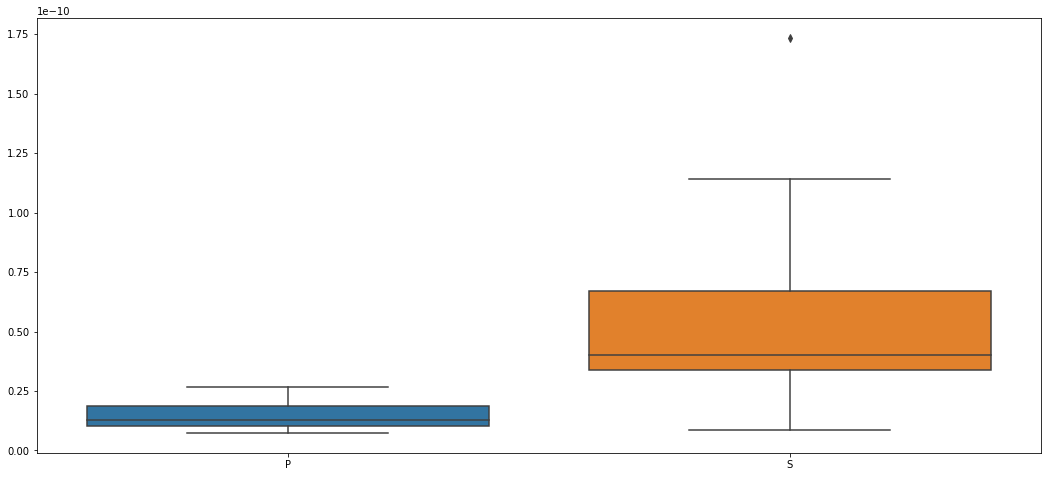

In [10]:
sns.boxplot(x=filenames, y=bandas_alpha)

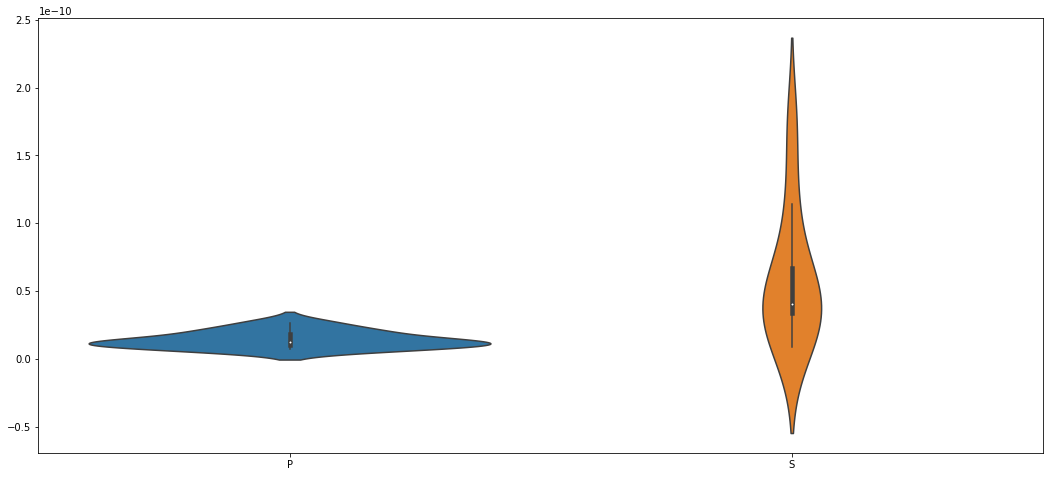

In [11]:
sns.violinplot(x=filenames, y=bandas_alpha)

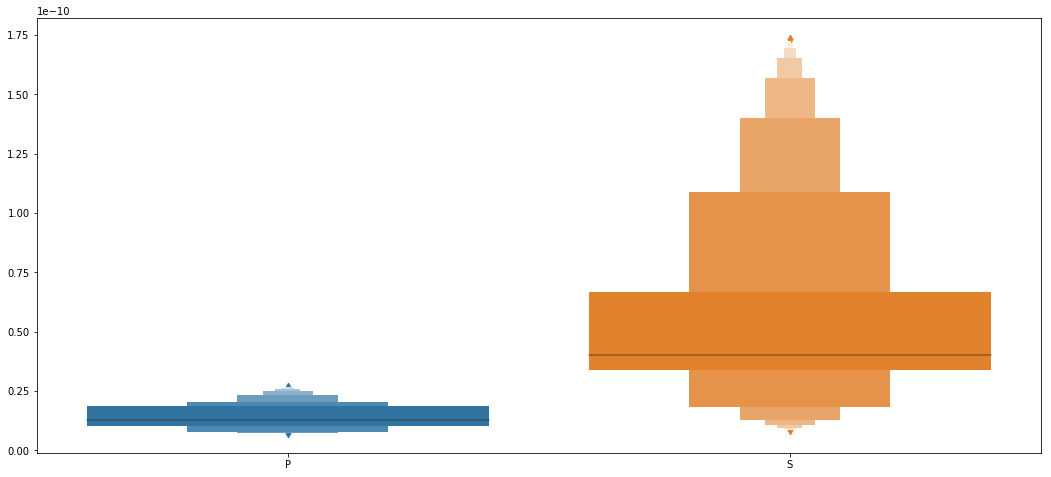

In [12]:
sns.lvplot(x=filenames, y=bandas_alpha)

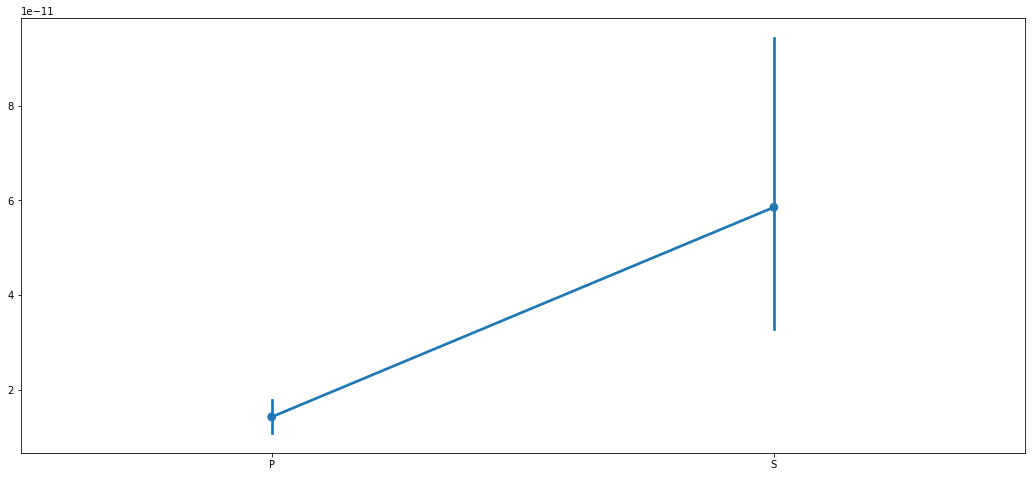

In [13]:
sns.pointplot(x=filenames, y=bandas_alpha)

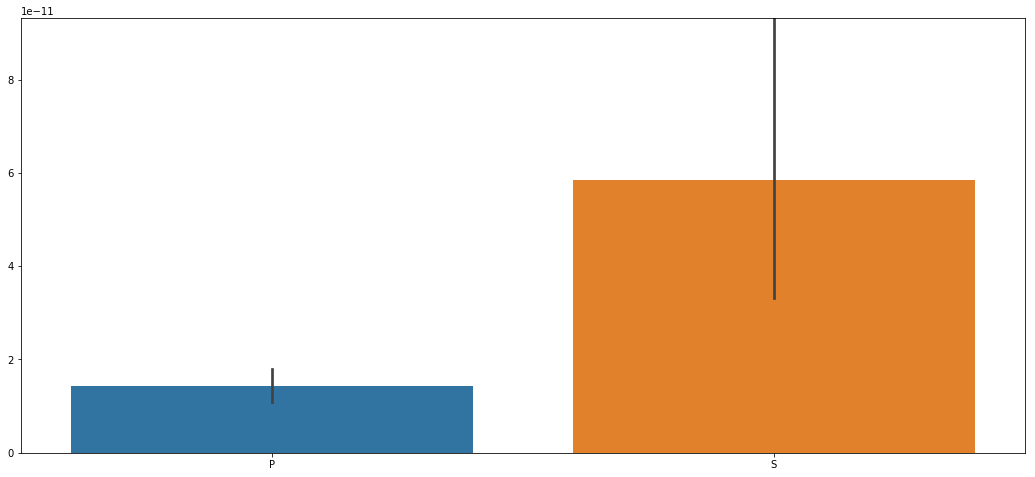

In [14]:
sns.barplot(x=filenames, y=bandas_alpha)

## ¿Cuál recomendaría para graficar y comparar distribuciones?

Recomendariamos utilizar graficos sobre violin plots. Usar boxplots tiene el riesgo de perder la variacion en la distribucion, si las medidas que el boxplot (cuartil, mediana, etc) usa se mantienen similares a pesar del cambio en los datos crudos. Al utilizar violin plots, se puede ver y comparar la variacion en las distribuciones deseadas, ya que ademas de la medidas de boxplot, violinplot se hace con KDE (Kernel Density Estimation).

## d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

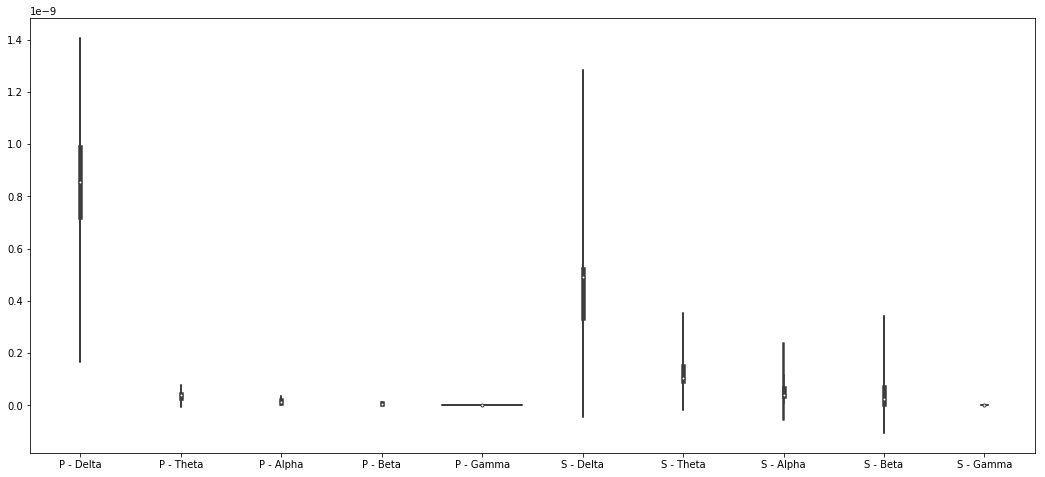

In [15]:
# Agrupamos todos los valores en categoria x bandas ({P|S} * {theta, alpha, beta, gamma, etc})

def violin_plot(bins):
    x, y = [], []
    for filename, datapoints in bins.items():
        letter = get_letter(filename)
        for index, value in enumerate(datapoints):
            try:
                label = letter + ' - ' + nombre_bandas[index]
            except IndexError:
                continue
            else:
                x.append(label)
                y.append(value)

    sns.violinplot(x=x, y=y)
    
violin_plot(bins_por_sujeto)

In [16]:
def t_test_banda_delta(bins):
    bandas_delta = {"P": [], "S": []}
    for filename, datapoints in bins.items():
        letter = get_letter(filename)
        bandas_delta[letter].append(datapoints[0])

    return stats.ttest_rel(bandas_delta['P'], bandas_delta['S'])
    
t_test_banda_delta(bins_por_sujeto)

Ttest_relResult(statistic=5.2585391928884491, pvalue=0.00052174491747482646)

Realizamos un T-test para comparar la distribución de las bandas Delta de los dos grupos de sujetos. 
La hipótesis nula es que las medias de ambas grupos son idénticas. Como el p-valor es menor a 0.05, podemos rechazar
esta hipótesis. Ademas, tomando en cuenta el valor estadístico, sabemos que la media de los sujetos 'P' es mayor a la de los 'S'. 
Esto se condice con el conocimiento científico acerca de que la alta actividad en la banda Delta se relaciona con la pérdida de conciencia, eg: 

"Delta waves and delta wave activity are marked, in most people, by an apparently unconscious state, and the loss of physical awareness" 
(https://en.wikipedia.org/wiki/Delta_wave#Consciousness_and_dreaming)

## e) Repetir los puntos b) y d) para los valores normalizados.

### Punto b

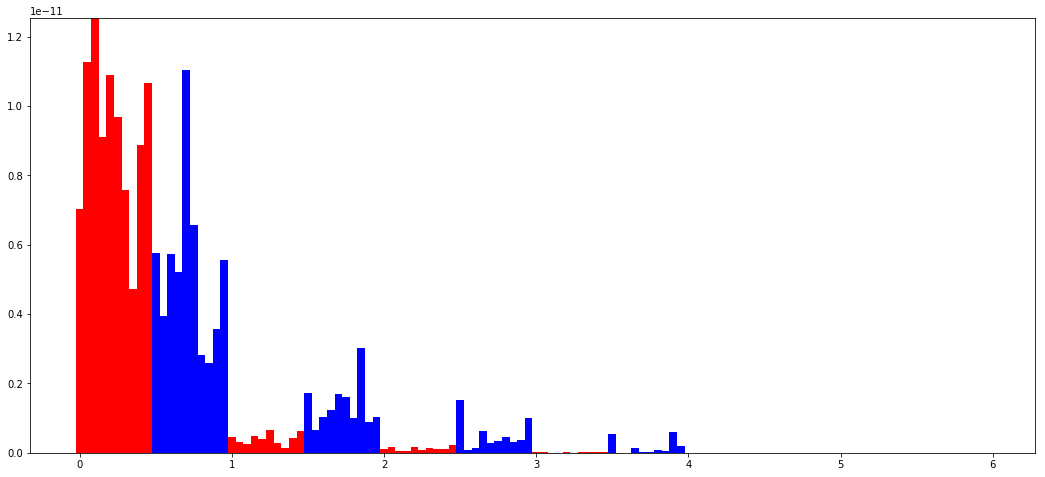

In [17]:
# Calculamos la cantidad de frecuencias que caen en cada banda.
counter = Counter(getBanda(frecuencia) for frecuencia in frecuencias)
cantidad_de_valores_por_banda = np.array(list(counter.values()) + [1])

bins_por_sujeto_normalizados = deepcopy(bins_por_sujeto)

for filename, datapoints in bins_por_sujeto_normalizados.items():
    datapoints /= cantidad_de_valores_por_banda

for index, filename in enumerate(allSubjects()):
    # Generamos un grafico de barras, separando por bandas y sujeto.
    # Los datos rojos corresponden a los sujetos P, mientras que los azules corresponden a los sujetos S.
    # El eje X contiene la separacion por bandas en orden Delta-Theta-Alfa-Beta-Gamma
    plt.bar(np.arange(len(bandas)) + index * barwidth, bins_por_sujeto_normalizados[filename], width=barwidth,
           color='red' if 'P' in filename else 'blue', label='bandas')

### Punto d

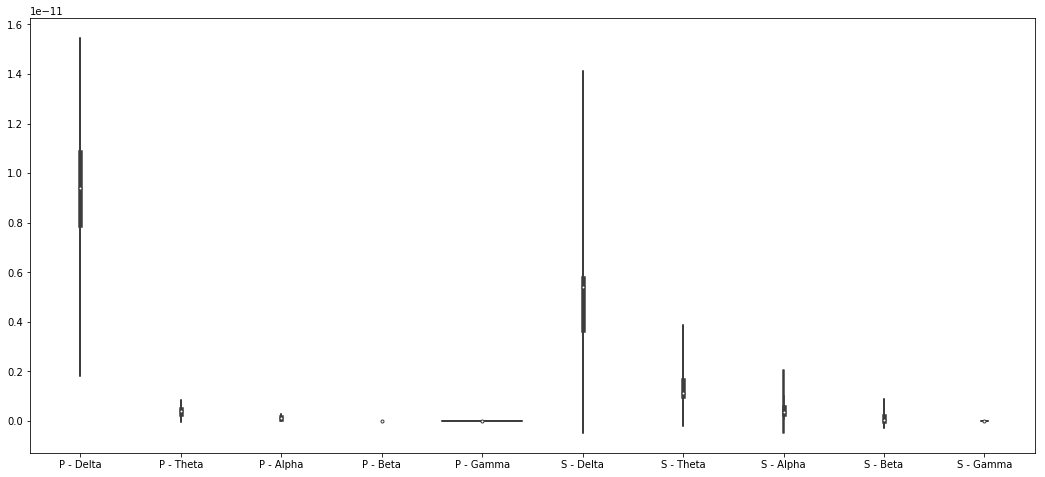

In [18]:
violin_plot(bins_por_sujeto_normalizados)

In [19]:
t_test_banda_delta(bins_por_sujeto_normalizados)

Ttest_relResult(statistic=5.2585391928884482, pvalue=0.00052174491747482646)

## 2.2 Análisis de información

a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

Como medida de información, elegimos la entropia de Shannon, por lo que debemos primero discretizar las frecuencias de los electrodos para luego calcularla.

In [8]:
def get_cantidad_de_bines(data, minimo, maximo):
    return np.ceil(
        (maximo - minimo)
        /
        (3.5 * np.std(data) * (len(data) ** (-1/3)))
    )

In [9]:
def get_min_max_cant():
    minimo, maximo, max_cantidad_de_bines = 0, 0, 0

    for index, filename in enumerate(allSubjects()):
        subject_data = loadSubject(filename)  # epoch, electrodo, muestra

        for epoch in subject_data:
            for num_electrodo in electrodos:
                electrodo = epoch[num_electrodo]
                minimo = min(np.min(electrodo), minimo)
                maximo = max(np.max(electrodo), maximo)
                max_cantidad_de_bines = max(get_cantidad_de_bines(electrodo, minimo, maximo),
                                            max_cantidad_de_bines)

    return minimo, maximo, max_cantidad_de_bines

minimo, maximo, cantidad_de_bines = get_min_max_cant()

Calculamos, sobre todos los datos, el mínimo, máximo y cantidad de bins necesarias para discretizar 
los datos de los electrodos según la regla de Scott. 

In [10]:
bins = np.linspace(minimo, maximo, cantidad_de_bines)

entropy_per_subject = {}

# Para cada sujeto discretizamos los datos de los electrodos, calculamos la entropía y la promediamos

for index, filename in enumerate(allSubjects()):
    subject_data = loadSubject(filename)  # epoch, electrodo, muestra
    subject_entropy, iter_count = 0.0, 0

    for epoch in subject_data:
        for num_electrodo in electrodos:
            electrodo = epoch[num_electrodo]
            hist, _ = np.histogram(electrodo, bins)
            subject_entropy += stats.entropy(hist, base=2)
            iter_count += 1   
            
    subject_entropy /= iter_count
    entropy_per_subject[filename] = subject_entropy
    


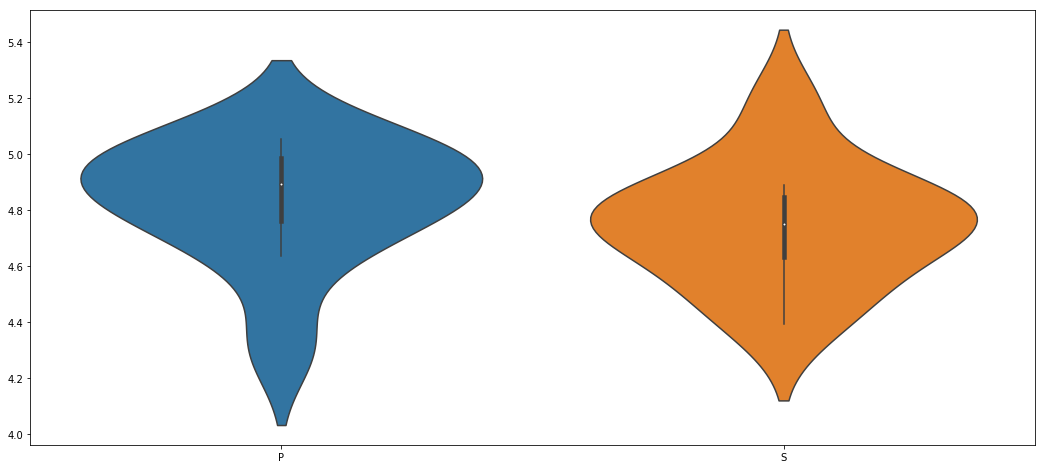

In [23]:
sns.violinplot(x=[get_letter(k) for k in entropy_per_subject.keys()],
               y=list(entropy_per_subject.values()))

Repetimos el test estadistico, pero utilizando las entropias agrupadas por sujeto como distribuciones.

In [24]:
stats.ttest_rel([v for k, v in entropy_per_subject.items() if 'P' in k],
                [v for k, v in entropy_per_subject.items() if 'S' in k])

Ttest_relResult(statistic=0.9505508672259485, pvalue=0.36665892610854878)

Si bien las distribuciones parecen tener leves diferencias, como el p-valor es mayor a 0.05, no podemos afirmar que la media de ambas distribuciones es significativamente distinta. Esto se condice con la aparente similitud mostrada en el violin plot.

#### b) Repetir el punto a) para una medida inter-electrodo.

Utilizamos como medida la información mutua

In [25]:
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [26]:
def mutual_info_for_subjects(a, b, num_epoch=0, num_electrodo=0):
    data_a = loadSubject(a)
    data_b = loadSubject(b)

    epoch_a, epoch_b = data_a[num_epoch], data_b[num_epoch]
    electrodo_a, electrodo_b = epoch_a[num_electrodo], epoch_b[num_electrodo]
    return calc_MI(electrodo_a, electrodo_b, bins)

Al ser demasiado costosa para calcular sobre todas las muestras, elegimos al azar unos pocos epochs y electrodos a samplear

In [27]:
epochs_a_samplear = sorted(random.sample(range(cant_muestras), 3))
electrodos_a_samplear = sorted(random.sample(range(cant_electrodos), 3))

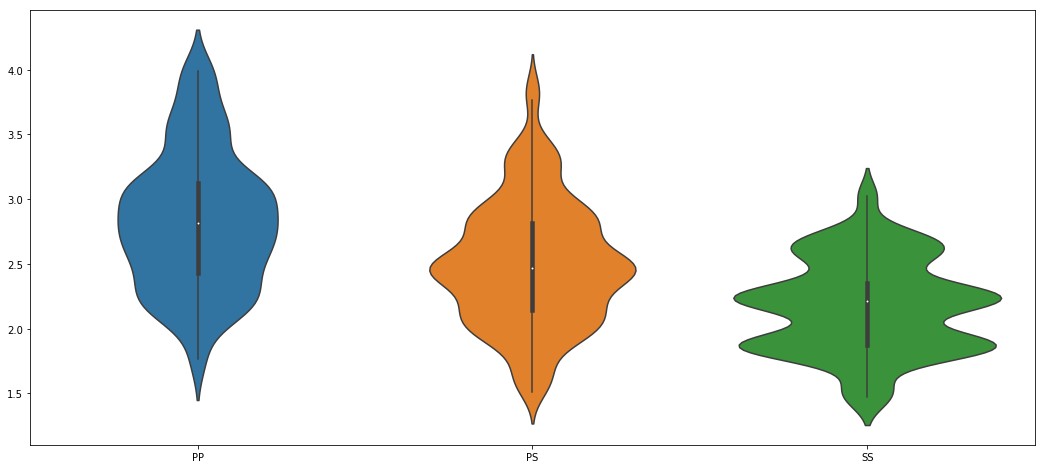

In [28]:
x, y = [], []
MIs = defaultdict(list)

for sujeto_1, sujeto_2 in combinations(allSubjects(), 2):
    for num_epoch, num_electrodo in product(epochs_a_samplear, electrodos_a_samplear):
        mi = mutual_info_for_subjects(sujeto_1, sujeto_2)
        label = ''.join(sorted([get_letter(sujeto_1), get_letter(sujeto_2)]))
        x.append(label)
        y.append(mi)
        MIs[label].append(mi)

sns.violinplot(x=x, y=y)

In [29]:
def ttest(d):
    for label1, label2 in combinations(d.keys(), 2):
        items1, items2 = d[label1], d[label2]
        min_l = min(len(items1), len(items2))
        print("{}/{}:".format(label1, label2), stats.ttest_rel(items1[:min_l], items2[:min_l]))

ttest(MIs)

PP/PS: Ttest_relResult(statistic=13.007094715509039, pvalue=1.4944688592506645e-32)
PP/SS: Ttest_relResult(statistic=17.96123059358229, pvalue=1.9060310430049311e-53)
PS/SS: Ttest_relResult(statistic=7.161521878153926, pvalue=3.8010479458919633e-12)


Parecería ser que la media de la información mutua entre dos sujetos 'P' es mayor que entre un sujeto P contra un sujeto S, y a su vez a mayor a dos sujetos S entre sí. Esto se interpreta como que saber algo sobre el comportamiento de un sujeto P aporta más información sobre el comportamiento de otro sujeto P, que de un sujeto S, y viceversa. Podemos distinguir claramente las clases y tal vez suponer que los pacientes P tienen un comportamiento más homogéneo.